In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

sys.path.append("../../")


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data_dir = '/nadeem_lab/Gunjan/data/impartial/cellpose/' ## This should be the file where the .npz files are

pd_file = pd.read_csv(data_dir + 'files.csv')
pd_file.to_csv(data_dir + 'files.csv')

print(pd_file) 
print()

#get number of instances per segmentation class
for i in range(len(pd_file)):
    group = pd_file['group'][i]
    print( data_dir + pd_file['input_file'][i])
    npz_read = np.load(data_dir + pd_file['input_file'][i])
    image = npz_read['image']        
    label = npz_read['label']
    
    #initialize lists
    if i == 0:
        if len(label.shape)>2:
            nclasses = label.shape[-1]
        else:
            nclasses = 1
        nlabels_class_train_list = [0 for i in range(nclasses)]
        nlabels_class_test_list = [0 for i in range(nclasses)]
    
    if len(label.shape)>2:
        for ix in range(label.shape[-1]):
            if group == 'train':
                nlabels_class_train_list[ix] += np.unique(label[...,ix]).shape[0] - 1
            else:
                nlabels_class_test_list[ix] += np.unique(label[...,ix]).shape[0] - 1
    else: #only one class
        if group == 'train':
            nlabels_class_train_list[0] += np.unique(label).shape[0] - 1
        else:
            nlabels_class_test_list[0] += np.unique(label).shape[0] - 1
        

print()
print('----')
print('total train instances per class (',nclasses, 'classes)')
print(nlabels_class_train_list)
print('total test instances per class (',nclasses, 'classes)')
print(nlabels_class_test_list)

    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0            0             0               0                 0   
1            1             1               1                 1   
2            2             2               2                 2   
3            3             3               3                 3   
4            4             4               4                 4   
..         ...           ...             ...               ...   
69          69            69              69                69   
70          70            70              70                70   
71          71            71              71                71   
72          72            72              72                72   
73          73            73              73                73   

                           prefix                         input_file  group  
0   000_img_cellpose_train_folder  000_img_cellpose_train_folder.npz  train  
1   001_img_cellpose_train_folder  001_img_cellpose

In [6]:
from skimage import morphology

def erosion_labels(label,radius_pointer=1): 
    #needed to generate scribbles from boundaries since in many cases 
    #there is no background between different instances
    selem = morphology.disk(radius_pointer)
    mask = np.zeros_like(label)
    for vlabel in np.unique(label):
        if vlabel != 0:
            mask_label = np.zeros_like(label)
            mask_label[label == vlabel] = 1
            aux = morphology.dilation(mask_label, selem=selem)
            if np.unique(aux*label).shape[0] > 2: #overlaps with other label
                erode_label = morphology.erosion(mask_label, selem=selem)
                mask[erode_label>0] = vlabel
            else:
                mask[mask_label>0] = vlabel
    ## Image Corners
    mask[:,0:radius_pointer] = label[:,0:radius_pointer]
    mask[:,-radius_pointer-1:] = label[:,-radius_pointer-1:]
    mask[0:radius_pointer,:] = label[0:radius_pointer,:]
    mask[-radius_pointer-1:,:] = label[-radius_pointer-1:,:]
    return mask

/nadeem_lab/Gunjan/data/impartial/cellpose/000_img_cellpose_train_folder.npz


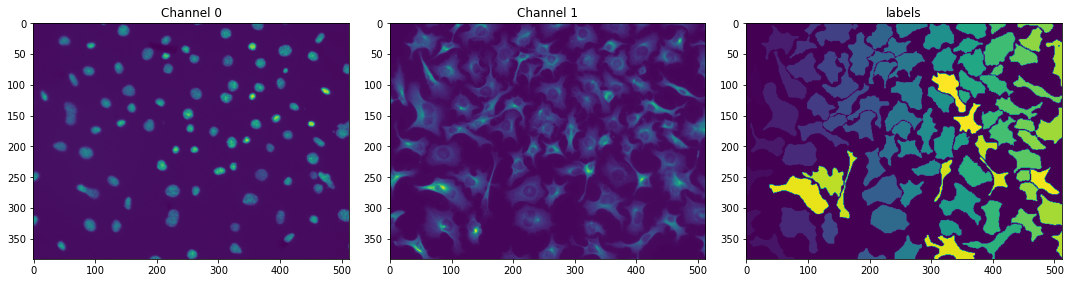

/nadeem_lab/Gunjan/data/impartial/cellpose/003_img_cellpose_train_folder.npz


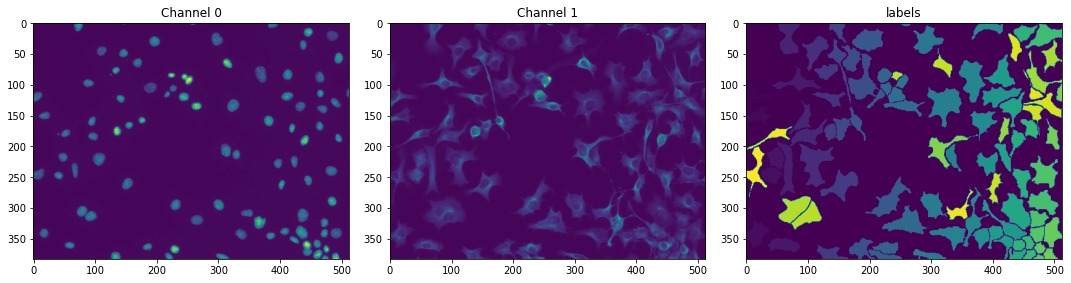

/nadeem_lab/Gunjan/data/impartial/cellpose/006_img_cellpose_train_folder.npz


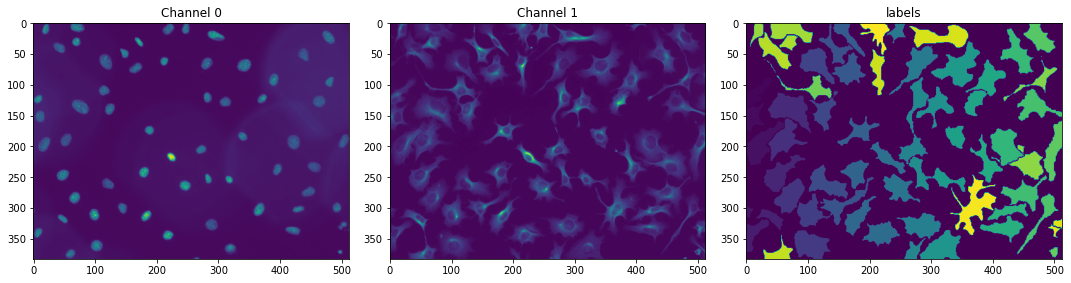

/nadeem_lab/Gunjan/data/impartial/cellpose/009_img_cellpose_train_folder.npz


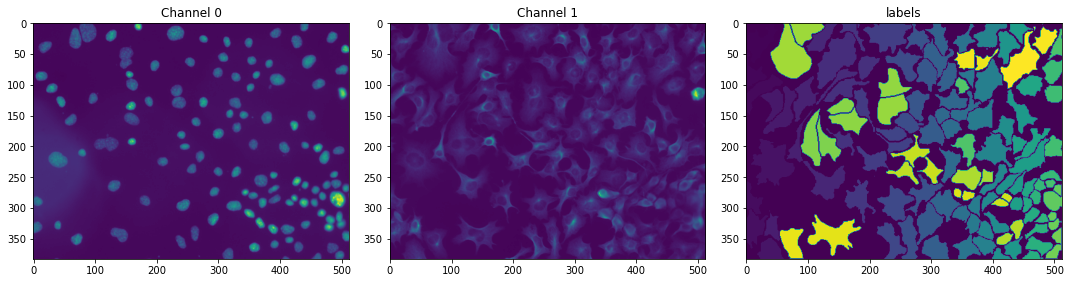

/nadeem_lab/Gunjan/data/impartial/cellpose/019_img_cellpose_train_folder.npz


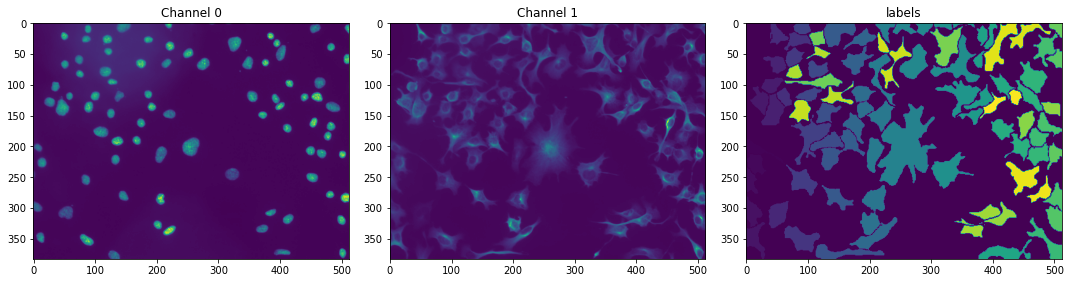

/nadeem_lab/Gunjan/data/impartial/cellpose/035_img_cellpose_train_folder.npz


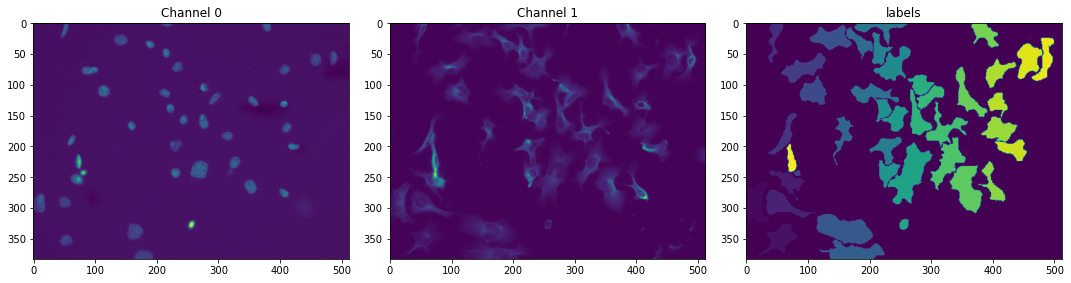

/nadeem_lab/Gunjan/data/impartial/cellpose/039_img_cellpose_train_folder.npz


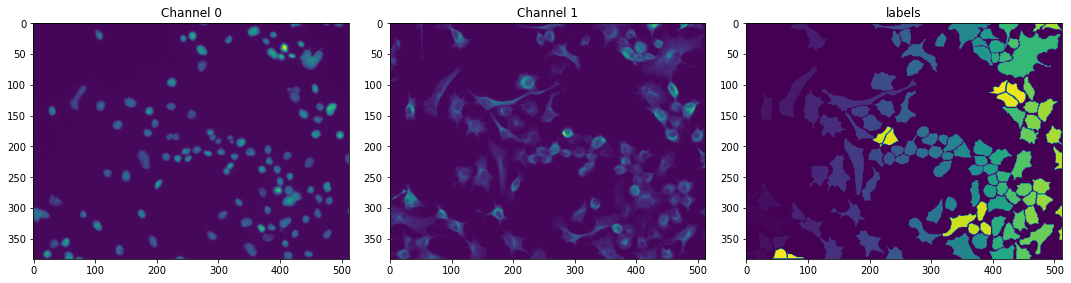

/nadeem_lab/Gunjan/data/impartial/cellpose/096_img_cellpose_train_folder.npz


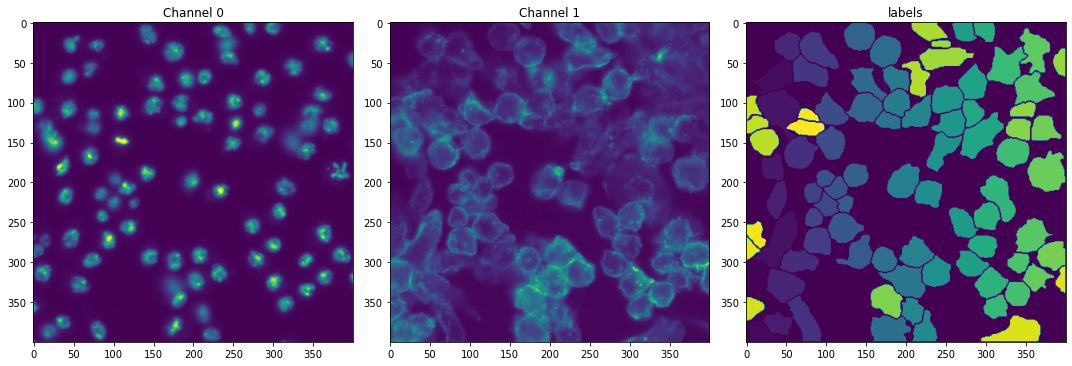

/nadeem_lab/Gunjan/data/impartial/cellpose/099_img_cellpose_train_folder.npz


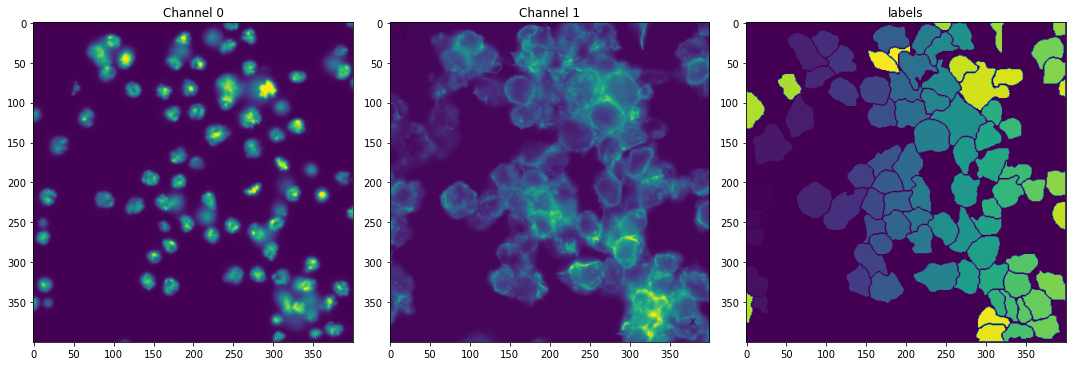

/nadeem_lab/Gunjan/data/impartial/cellpose/102_img_cellpose_train_folder.npz


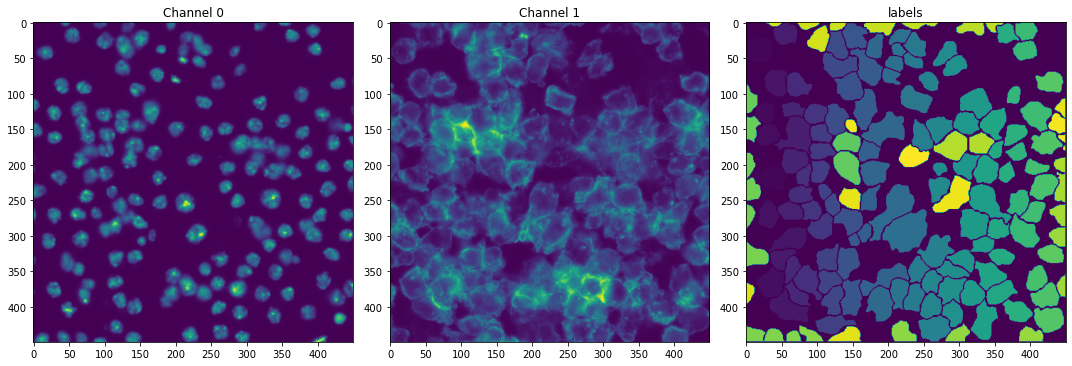

In [7]:
from dataprocessing.labelgeneration import get_scribbles

#load train segmentations in a list
X_train_list = []

Y_gt_train_ch0_list = []

files_train_list_aux = []

nlabels_total0 = 0

for i in range(len(pd_file)):
    group = pd_file['group'][i]
    if group == 'train':

        print( data_dir + pd_file['input_file'][i])
        npz_read = np.load(data_dir + pd_file['input_file'][i])
        image = npz_read['image']        
        label0 = npz_read['label']
        label0 = erosion_labels(label0,radius_pointer=1)
        nlabels_total0 += np.unique(label0).shape[0]-1
        
        X_train_list.append(image)
        Y_gt_train_ch0_list.append(label0)
        
        files_train_list_aux.append([data_dir,
                                 pd_file['input_file'][i],
                                 pd_file['prefix'][i],])

        plt.figure(figsize=(15,5))
        
        plt.subplot(1,3,1)
        plt.title('Channel 0')
        plt.imshow(image[...,0])
        
        plt.subplot(1,3,2)
        plt.title('Channel 1')
        plt.imshow(image[...,1])
        
        
        plt.subplot(1,3,3)
        plt.title('labels')
        plt.imshow(label0)
        
        plt.tight_layout()
        plt.show()

In [8]:
Y_out_ch0_list = []
nscribbles_ch0_list = []
nlabels_ch0_list = []

for ix in range(len(Y_gt_train_ch0_list)):
    scribbles = np.zeros([Y_gt_train_ch0_list[ix].shape[0],Y_gt_train_ch0_list[ix].shape[1],2])
    
    
    labels = np.array(Y_gt_train_ch0_list[ix])
    foreground = np.zeros_like(labels)
    foreground[labels>0] = 1
    scribbles[:,:,0] = foreground
    
    background = np.zeros_like(labels)
    background[labels==0] = 1
    scribbles[:,:,1] = background
    
    Y_out_ch0_list.append(scribbles)
    nscribbles_ch0_list.append(np.unique(labels).shape[0]-1)
    nlabels_ch0_list.append(np.unique(labels).shape[0]-1)
    

0 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '000_img_cellpose_train_folder.npz', '000_img_cellpose_train_folder']
000_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
100784 196 432
44 196 228 432
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/000_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


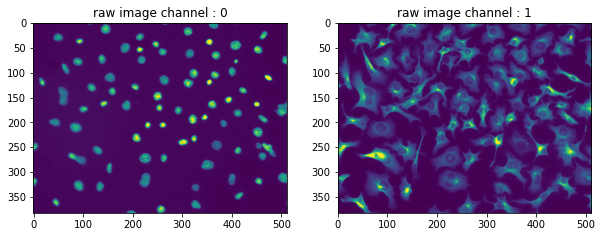

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


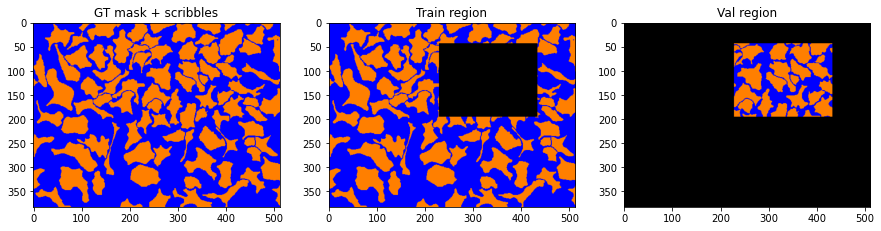

1 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '003_img_cellpose_train_folder.npz', '003_img_cellpose_train_folder']
003_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
124209 242 305
90 242 101 305
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/003_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


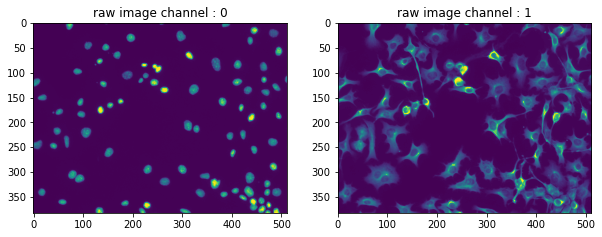

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


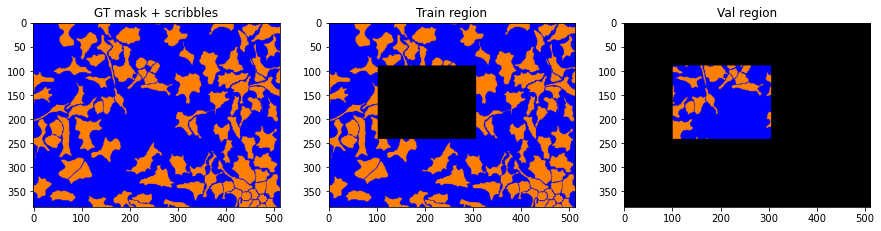

2 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '006_img_cellpose_train_folder.npz', '006_img_cellpose_train_folder']
006_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
38041 74 153
0 152 0 204
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/006_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


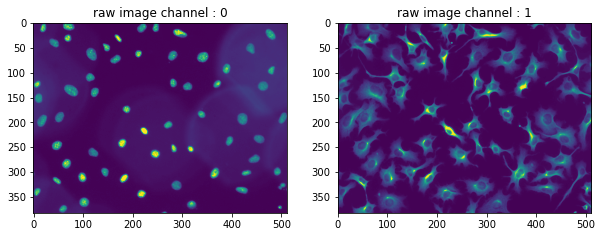

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


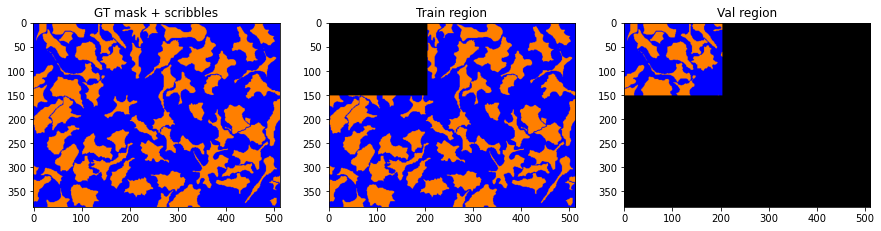

3 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '009_img_cellpose_train_folder.npz', '009_img_cellpose_train_folder']
009_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
143744 280 384
128 280 180 384
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/009_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


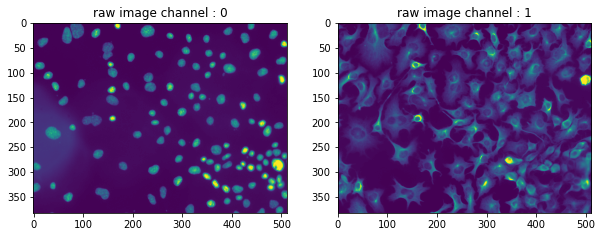

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


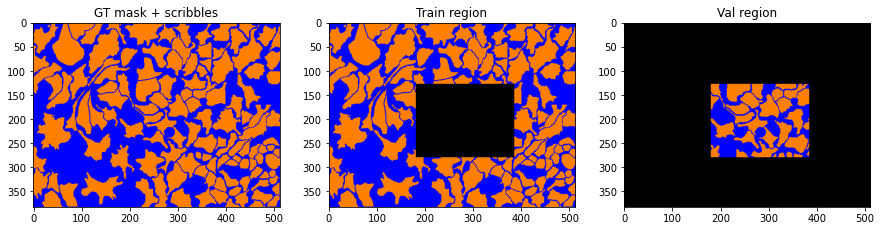

4 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '019_img_cellpose_train_folder.npz', '019_img_cellpose_train_folder']
019_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
189686 370 246
218 370 42 246
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/019_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


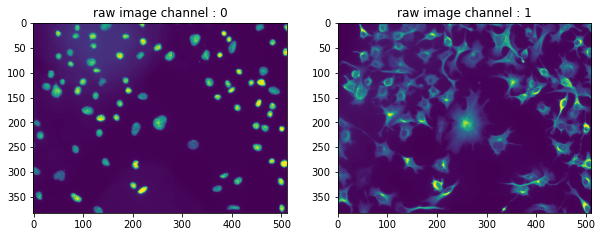

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


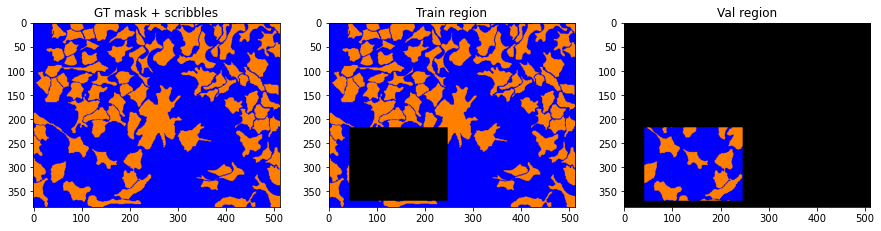

5 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '035_img_cellpose_train_folder.npz', '035_img_cellpose_train_folder']
035_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
49991 97 327
0 152 123 327
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/035_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


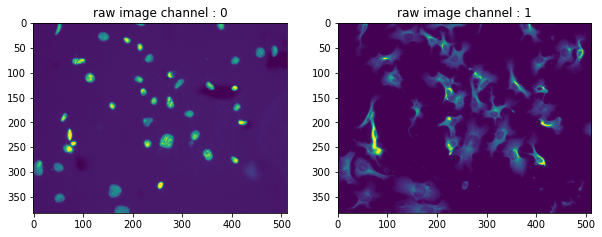

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


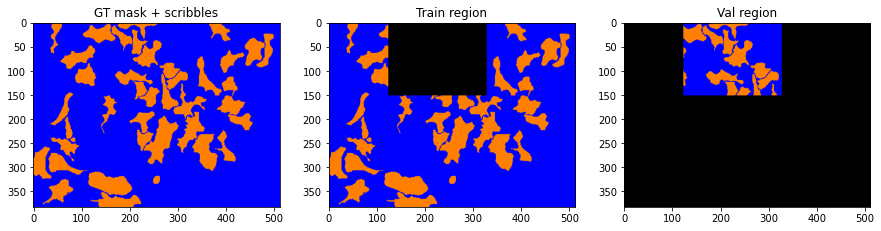

6 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '039_img_cellpose_train_folder.npz', '039_img_cellpose_train_folder']
039_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
87377 170 337
18 170 133 337
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/039_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


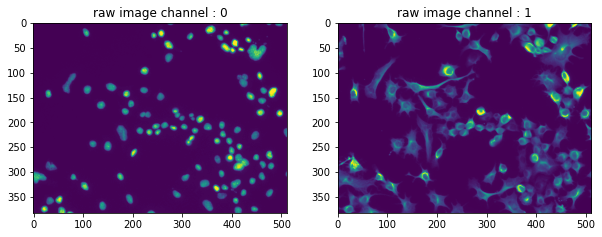

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


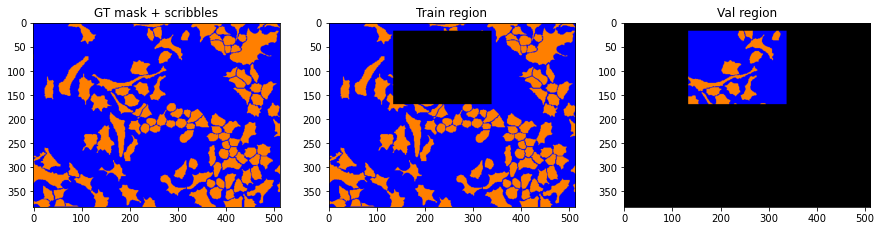

7 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '096_img_cellpose_train_folder.npz', '096_img_cellpose_train_folder']
096_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
30208 75 208
0 160 48 208
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/096_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


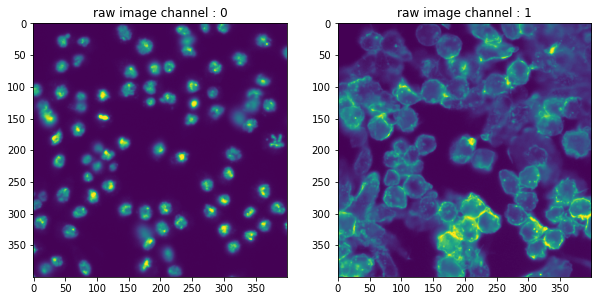

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


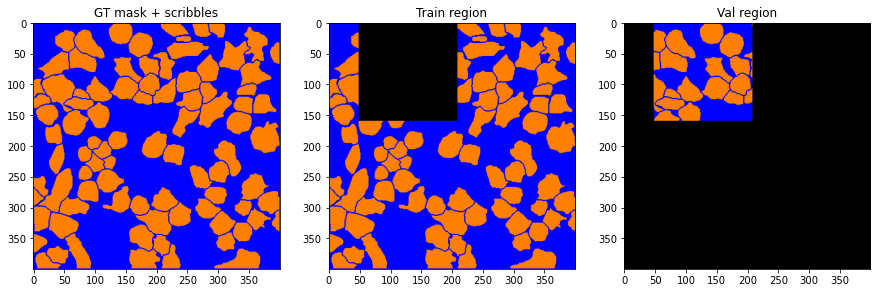

8 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '099_img_cellpose_train_folder.npz', '099_img_cellpose_train_folder']
099_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
9922 24 322
0 160 162 322
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/099_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


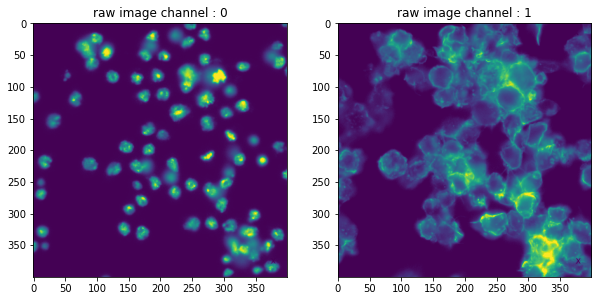

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


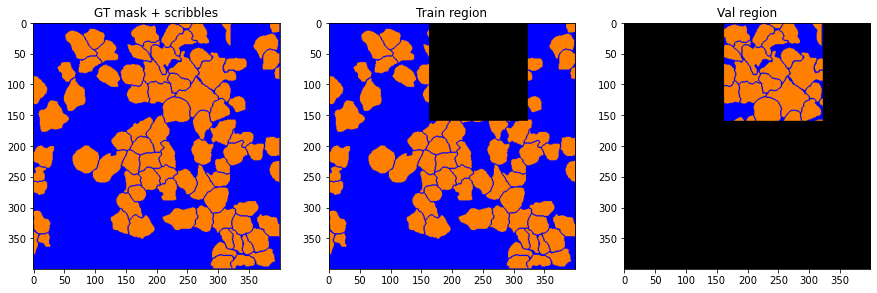

9 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '102_img_cellpose_train_folder.npz', '102_img_cellpose_train_folder']
102_img_cellpose_train_folder_1task1class_10images_fulllabels.npz
92903 206 203
26 206 23 203
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/102_img_cellpose_train_folder_1task1class_10images_fulllabels.npz


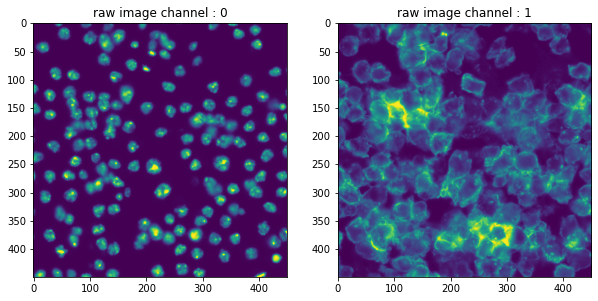

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [1.]


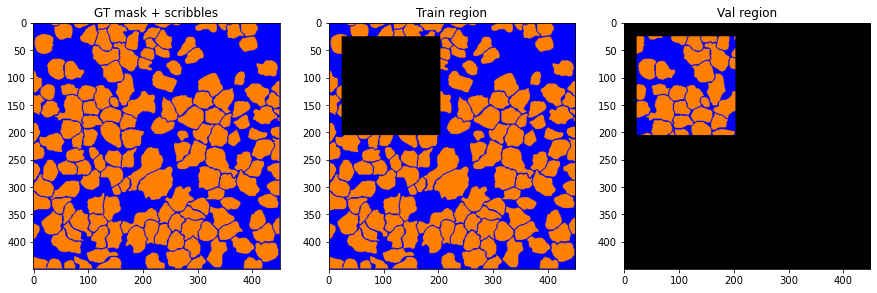

In [9]:
## Save scribbles
val_perc = 0.4
import copy
from csbdeep.utils import normalize

np.random.seed(9)
np.random.seed(44)


files_train_list = copy.deepcopy(files_train_list_aux)
for i in range(len(files_train_list)):
    
    image = X_train_list[i]
    label_gt = Y_gt_train_ch0_list[i][...,np.newaxis] 
    scribbles_ch = [Y_out_ch0_list[i]]
    
    
    ### save scribbles file name
    print(i,files_train_list[i])
    name_save = files_train_list[i][1].split('.')[0] + '_1task1class_10images_fulllabels.npz'
    print(name_save)
    files_train_list[i].extend([name_save])
    
    ### save number of labels with scribbles per channel
    for ch in np.arange(len(scribbles_ch)):
        label_ch = label_gt[...,ch]
        s_ch = scribbles_ch[ch]

        #nlabels with scribbles
        label_wscribble = np.unique(label_ch[s_ch[...,0]>0].flatten())
        nscribbles = label_wscribble.shape[0]
        nlabels = np.unique(label_ch[label_ch>0]).shape[0]
        pixels_scribbled_TP = np.round(100*np.sum(s_ch[...,0]>0)/ (np.sum(label_ch>0)),2)
        pixels_scribbled_TN = np.round(100*np.sum(s_ch[...,1]>0)/ (np.sum(label_ch==0)),2)
        files_train_list[i].extend([int(nlabels),int(nscribbles),
                                    label_wscribble,pixels_scribbled_TP,pixels_scribbled_TN])
    
    ### Define classification tasks and their scribbles
    tasks_classes = {'0':[0]}
    
    scribble = None
    for tasks in tasks_classes.keys():
        start_task = True
        for ch in tasks_classes[tasks]:
            
            s_ch = scribbles_ch[ch]
            
            label_ch = np.array(label_gt)
            label_ch[...,ch] = 0
            label_ch = label_ch[...,tasks_classes[tasks]]
            label_ch[label_ch>0] = 1
            label_ch = np.sum(label_ch,-1)
            
            if start_task:
                background = np.array(s_ch[...,1])*(1-label_ch) + 0 #make sure no foreground is set as background
                scribble_task = np.array(s_ch[...,0])[...,np.newaxis] + 0
                start_task = False
            else:
                background += np.array(s_ch[...,1])*(1-label_ch) #make sure no foreground is set as background
                scribble_task = np.concatenate([scribble_task, np.array(s_ch[...,0])[...,np.newaxis]],axis = -1)
                
        scribble_task = np.concatenate([scribble_task,background[...,np.newaxis]],axis = -1)
        scribble_task[scribble_task>0] = 1
        
        if scribble is None:
            scribble = np.array(scribble_task)
        else:
            scribble = np.concatenate([scribble,scribble_task],axis = -1)
                
    
    ### validation sample region mask ###
    region_val_size = [int(image.shape[0] * val_perc/2),int(image.shape[1] * val_perc/2)] #validation region
    mask_scribbles = np.sum(scribble,axis = -1)
    mask_scribbles[mask_scribbles>0] = 1
    from scipy import ndimage
    mask_scribbles = ndimage.convolve(mask_scribbles, np.ones([5,5]), mode='constant', cval=0.0)
    #remove borders
#     mask_scribbles[-region_val_size[0]:,:] = 0
#     mask_scribbles[:,-region_val_size[1]:] = 0
#     mask_scribbles[0:region_val_size[0],:] = 0
#     mask_scribbles[:,0:region_val_size[1]] = 0
    val_center = np.random.multinomial(1, mask_scribbles.flatten()/np.sum(mask_scribbles.flatten()), size=1).flatten()
    ix_center = np.argmax(val_center)
    ix_row = int(np.floor(ix_center/image.shape[1]))
    ix_col = int(ix_center - ix_row * image.shape[1])
    print(ix_center,ix_row,ix_col)
    
    row_low = np.maximum(ix_row - region_val_size[0], 0)
    row_high = np.minimum(row_low + region_val_size[0], image.shape[0])
    row_low = np.maximum(row_high - 2*region_val_size[0], 0)
    row_high = np.minimum(row_low+ 2*region_val_size[0], image.shape[0])
    
    col_low = np.maximum(ix_col - region_val_size[1], 0)
    col_high = np.minimum(col_low + region_val_size[1], image.shape[1])
    col_low = np.maximum(col_high - 2*region_val_size[1], 0)
    col_high = np.minimum(col_low + 2*region_val_size[1], image.shape[1])
    print(row_low,row_high,col_low, col_high)
    
    validation_mask = np.zeros([image.shape[0], image.shape[1]])
    validation_mask[row_low:row_high,
                    col_low:col_high] = 1
#     validation_mask[ix_row-region_val_size[0]:ix_row+region_val_size[0],
#                     ix_col-region_val_size[1]:ix_col+region_val_size[1]] = 1
    
    ## saving
    print('check unique values scribbles :', np.unique(scribble))
    print(files_train_list[i][0] + name_save)
    np.savez(files_train_list[i][0] + name_save, scribble=scribble, val_mask = validation_mask)
    
    ############################################# Plots #############################################
    #plot input channels
    plt.figure(figsize=(10,5))
    ix = 0
    for ch in range(image.shape[-1]):
        image_plot = normalize(image[...,ch], pmin=1, pmax=99.8, clip = True)
        plt.subplot(1, image.shape[-1], ix + 1)
        ix += 1
        plt.title('raw image channel : ' + str(ch))
        plt.imshow(image_plot)
    plt.show()
    
    itask = 0
    for tasks in tasks_classes.keys():
        classes_lists = tasks_classes[tasks]
        print(' task '+ str(tasks) + ' ; classes :',classes_lists)
        
        label_ch = np.array(label_gt[...,classes_lists])
        label_ch[label_ch>0] = 1
        label_ch = np.sum(label_ch*(np.arange(len(classes_lists))+1)[np.newaxis,np.newaxis,:],-1)
        print('check sum of scribbles on same class (=1 or 0) :',
              np.unique(np.sum(scribble[...,itask:itask+len(classes_lists)+1],-1)))
        
        aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
        aux[...,1] = label_ch*0.5/len(classes_lists)
        aux[...,0] = np.sum(scribble[...,itask:itask+len(classes_lists)],-1)
        aux[...,2] = scribble[...,itask+len(classes_lists)]
        itask += len(classes_lists)+1
        
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.title('GT mask + scribbles')
        plt.imshow(aux)

        plt.subplot(1,3,2)
        plt.title('Train region')
        plt.imshow(aux*(1-validation_mask[...,np.newaxis]))

        plt.subplot(1,3,3)
        plt.title('Val region')
        plt.imshow(aux*validation_mask[...,np.newaxis])
        plt.show()

In [10]:
columns = ['input_dir','input_file','prefix','scribble_file']
for ch in np.arange(1):
    for col in ['total_labels','scribble_labels',
                'label_with_scribble','perc_pixels_scribbles_TP','perc_pixels_scribbles_TN']:
        columns.append(col+'_class' + str(ch))

pd_scribbles = pd.DataFrame(data=files_train_list, columns=columns)

for task in tasks_classes.keys():
    pd_scribbles['gt_index_task' + task] = [tasks_classes[task] for _ in range(len(pd_scribbles))]

print('Saving in: ')
namefile = data_dir + 'files_1task1class_10images_scribble_train_fulllabels.csv'
print(namefile)
pd_scribbles.to_csv(namefile, index=None)

pd_scribbles

Saving in: 
/nadeem_lab/Gunjan/data/impartial/cellpose/files_1task1class_10images_scribble_train_fulllabels.csv


input_dir  \
0  /nadeem_lab/Gunjan/data/impartial/cellpose/   
1  /nadeem_lab/Gunjan/data/impartial/cellpose/   
2  /nadeem_lab/Gunjan/data/impartial/cellpose/   
3  /nadeem_lab/Gunjan/data/impartial/cellpose/   
4  /nadeem_lab/Gunjan/data/impartial/cellpose/   
5  /nadeem_lab/Gunjan/data/impartial/cellpose/   
6  /nadeem_lab/Gunjan/data/impartial/cellpose/   
7  /nadeem_lab/Gunjan/data/impartial/cellpose/   
8  /nadeem_lab/Gunjan/data/impartial/cellpose/   
9  /nadeem_lab/Gunjan/data/impartial/cellpose/   

                          input_file                         prefix  \
0  000_img_cellpose_train_folder.npz  000_img_cellpose_train_folder   
1  003_img_cellpose_train_folder.npz  003_img_cellpose_train_folder   
2  006_img_cellpose_train_folder.npz  006_img_cellpose_train_folder   
3  009_img_cellpose_train_folder.npz  009_img_cellpose_train_folder   
4  019_img_cellpose_train_folder.npz  019_img_cellpose_train_folder   
5  035_img_cellpose_train_folder.npz  035_img_cellpose_train_folder   
6  039_img_cellpose_train_folder.npz  039_img_cellpose_train_folder   
7  096_img_cellpose_train_folder.npz  096_img_cellpose_train_folder   
8  099_img_cellpose_train_folder.npz  099_img_cellpose_train_folder   
9  102_img_cellpose_train_folder.npz  102_img_cellpose_train_folder   

                                       scribble_file  total_labels_class0  \
0  000_img_cellpose_train_folder_1task1class_10im...                   90   
1  003_img_cellpose_train_folder_1task1class_10im...                   94   
2  006_img_cellpose_train_folder_1task1class_10im...                   65   
3  009_img_cellpose_train_folder_1task1class_10im...                  121   
4  019_img_cellpose_train_folder_1task1class_10im...                   90   
5  035_img_cellpose_train_folder_1task1class_10im...                   40   
6  039_img_cellpose_train_folder_1task1class_10im...                  111   
7  096_img_cellpose_train_folder_1task1class_10im...                   88   
8  099_img_cellpose_train_folder_1task1class_10im...                   86   
9  102_img_cellpose_train_folder_1task1class_10im...                  154   

   scribble_labels_class0                         label_with_scribble_class0  \
0                      90  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1                      94  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2                      65  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3                     121  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4                      90  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5                      40  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6                     111  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7                      88  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8                      86  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9                     154  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

   perc_pixels_scribbles_TP_class0  perc_pixels_scribbles_TN_class0  \
0                            100.0                            100.0   
1                            100.0                            100.0   
2                            100.0                            100.0   
3                            100.0                            100.0   
4                            100.0                            100.0   
5                            100.0                            100.0   
6                            100.0                            100.0   
7                            100.0                            100.0   
8                            100.0                            100.0   
9                            100.0                            100.0   

  gt_index_task0  
0            [0]  
1            [0]  
2            [0]  
3            [0]  
4            [0]  
5            [0]  
6            [0]  
7            [0]  
8            [0]  
9  